In [26]:
#import pandas as pd
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os
import matplotlib.pyplot as plt
import pickle

#from tslearn.utils import to_time_series_dataset
#from tslearn.clustering import TimeSeriesKMeans

from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.k_medoids import TimeSeriesKMedoids

import warnings
warnings.filterwarnings('ignore')

fase = '02b_DTW'

In [27]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [28]:
folder = gen_config['folder']

#entradas
path_norm = gen_config['path_norm']
path_prod_stats = gen_config['path_prod_stats']
path_overall_prod_stats = gen_config['path_overall_prod_stats']
#salidas
path_dtw = gen_config['path_dtw']
path_traindtw = gen_config['path_traindtw']
path_fitdtw = gen_config['path_fitdtw']
#variables
clusters = gen_config['var_clusters']
path_dtwmodel = gen_config['path_dtw_model']
leer_pickle_dtw = gen_config['var_leer_pickle_dtw']
ejecutar_dtw = gen_config['var_ejecutar_dtw']


print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
----------------------------------------------02b_DTW-----------------------------------------------


In [29]:
df_norm = pl.read_parquet(f"{folder}/{path_norm}")
prod_stats = pl.read_parquet(f'{folder}/{path_prod_stats}')
overall_prod_stats = pl.read_parquet(f'{folder}/{path_overall_prod_stats}')

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")

df_norm shape:   (5_303_555,19)


In [30]:
df_norm = df_norm.with_columns([
    ((pl.col("periodo").cast(pl.Utf8) + "01").str.to_date("%Y%m%d")).alias("periodo_dt"),  
])

In [31]:
primer_periodo = df_norm['periodo_dt'].min()
df_norm['periodo','periodo_dt']

df_norm = df_norm.with_columns(
    ((pl.col('periodo_dt').dt.year() - primer_periodo.year) * 12 +
    (pl.col('periodo_dt').dt.month() - primer_periodo.month)).alias('mes_indice')
)

In [32]:
fijos = 150
sample = 100

productos_fijos = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[:fijos][:,0]
productos_sample = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[fijos:][:,0].sample(sample, seed=42)
productos_otros = overall_prod_stats['product_id'].filter(~overall_prod_stats['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))

In [33]:
df_norm = df_norm.sort(by=['product_id', 'customer_id', 'periodo'])

df_train = df_norm.filter(df_norm['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))
df_fit = df_norm.filter(df_norm['product_id'].is_in(productos_otros))

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")
print(f"df_train shape:  ({df_train.shape[0]:>9_d},{df_train.shape[1]:_d})")
print(f"df_fit shape:    ({df_fit.shape[0]:>9_d},{df_fit.shape[1]:_d})")

df_norm shape:   (5_303_555,19)
df_train shape:  (2_193_198,19)
df_fit shape:    (3_110_357,19)


In [34]:
prod_stats = prod_stats.to_pandas()
df_train = df_train.to_pandas()
df_fit = df_fit.to_pandas()

In [35]:
prodcust_train = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
prodcust_fit = df_fit[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
meses = pd.DataFrame({'mes_indice': df_train['mes_indice'].unique()})

print(f"prodcust_train series:  ({prodcust_train.shape[0]:>9_d},{df_train.shape[1]:_d}, productos unicos: {df_train['product_id'].nunique()})")
print(f"prodcust_fit series:    ({prodcust_fit.shape[0]:>9_d},{df_fit.shape[1]:_d}, productos unicos: {df_fit['product_id'].nunique()})")

prodcust_train series:  (   67_259,19, productos unicos: 250)
prodcust_fit series:    (  111_425,19, productos unicos: 530)


In [36]:
X_train = prodcust_train.merge(meses, how='cross')
X_train = X_train.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_train['prodcust'] = X_train['product_id'].astype(str) + '_' + X_train['customer_id'].astype(str)
X_train = X_train.drop(columns=['product_id', 'customer_id'])
X_train.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_train: {X_train['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_train['tn_norm'] = X_train['tn_norm'].fillna(0)
print(f"X_train series:    ({X_train.shape[0]:>9_d},{X_train.shape[1]:_d})")

Nulos en X_train: 228126. Se reemplazan por ceros
X_train series:    (2_421_324,1)


In [37]:
X_fit = prodcust_fit.merge(meses, how='cross')
X_fit = X_fit.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_fit['prodcust'] = X_fit['product_id'].astype(str) + '_' + X_fit['customer_id'].astype(str)
X_fit = X_fit.drop(columns=['product_id', 'customer_id'])
X_fit.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_fit: {X_fit['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_fit['tn_norm'] = X_fit['tn_norm'].fillna(0)
print(f"X_fit series:    ({X_fit.shape[0]:>9_d},{X_fit.shape[1]:_d})")

Nulos en X_fit: 4011300. Se reemplazan por ceros
X_fit series:    (4_011_300,1)


In [38]:
start_time = datetime.now()

model = TimeSeriesKMeans(n_clusters=clusters[0],
                        metric="dtw",
                        init_algorithm = 'forgy',
                        n_init=3, max_iter=200, tol=0.001,
                        verbose = True,
                        #averaging_method='mean',
                        random_state=42
                        )
x_clusters_dtw = model.fit_predict(X_train)
print(f"FINALIZADO! clusters: {model.n_clusters}, inertia: {model.inertia_:.2f}, time: {(datetime.now()-start_time).total_seconds():.2f}")

Iteration 0, inertia 555404573979.8353.
Iteration 1, inertia 549473568008.9123.
Iteration 2, inertia 526031611095.2355.
Iteration 3, inertia 502833073739.3876.
Iteration 4, inertia 483521393508.5728.
Iteration 5, inertia 459040085577.53375.
Iteration 6, inertia 428483676266.37964.
Iteration 7, inertia 400860042997.55444.
Iteration 8, inertia 386459011674.2316.
Iteration 9, inertia 374401710881.3189.
Iteration 10, inertia 362214402493.69696.
Iteration 11, inertia 347418049919.1299.
Iteration 12, inertia 347155903205.8286.
Iteration 13, inertia 346926083170.4835.
Iteration 14, inertia 346887849344.76337.
Iteration 15, inertia 346667876931.81995.
Iteration 16, inertia 346656617509.51166.
Iteration 17, inertia 346631428332.41327.
Iteration 18, inertia 346451191555.12335.
Iteration 19, inertia 337333605271.98755.
Iteration 20, inertia 329580227827.62585.
Iteration 21, inertia 329502173000.0678.
Iteration 22, inertia 329232348814.57135.
Iteration 23, inertia 329227145752.4045.
Iteration 24, 

In [49]:
model.save(f"{folder}/{path_dtwmodel}", serialization_format='pickle')

<zipfile.ZipFile filename='Experimentos\\2024-07-09_Candidato\\02b_dtw_model.zip' mode='r'>

In [50]:
x_clusters_dtw_fit = model.predict(X_fit)

In [51]:
#from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
#plot_cluster_algorithm(model, X_fit[:100], model.n_clusters)

In [52]:
df_clusters = pd.concat([prodcust_train.reset_index(drop=True), pd.DataFrame(x_clusters_dtw)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters.columns = cols

In [53]:
df_clusters_fit = pd.concat([prodcust_fit.reset_index(drop=True), pd.DataFrame(x_clusters_dtw_fit)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters_fit.columns = cols

In [54]:
df_clusters_full = pd.concat([df_clusters, df_clusters_fit], axis=0)
df_clusters_full.to_parquet(f"{folder}/{path_dtw}", index=False)

print(f"df_clusters_full series:  ({df_clusters_full.shape[0]:>9_d},{df_clusters_full.shape[1]:_d}, productos unicos: {df_clusters_full['product_id'].nunique()})")

df_clusters_full series:  (  178_684,3, productos unicos: 780)


In [55]:
report = df_clusters_full.groupby(f'cluster_dtw_{clusters[0]:0>2}').agg(['count', 'nunique'])

print('Clusters de DTW: Reporte')
print(report)

Clusters de DTW: Reporte
               product_id         customer_id        
                    count nunique       count nunique
cluster_dtw_15                                       
0                       8       8           8       7
1                    4058     250        4058     470
2                    6240     241        6240     458
3                     231      46         231     154
4                     102      22         102      86
5                     133      32         133     102
6                    5244     249        5244     423
7                  122348     780      122348     523
8                   13533     233       13533     455
9                    5148     202        5148     417
10                   6632     250        6632     485
11                   6451     214        6451     398
12                   1368     240        1368     367
13                    411     110         411     200
14                   6777     201        6777     405


In [56]:
dibu = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
dibu['cluster'] = x_clusters_dtw
dibu = dibu.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id'], how='left')
dibu = dibu.pivot(index=['product_id','customer_id','cluster'], columns='mes_indice', values='tn_norm').reset_index()

In [80]:
dibu_sample

mes_indice,product_id,customer_id,cluster,0,1,2,3,4,5,6,...,26,27,28,29,30,31,32,33,34,35
59832,20701,10219,14,3.628735,2.110617,0.518118,0.369994,0.703751,0.740623,0.000000,...,2.628735,0.000000,0.444374,0.481246,0.369994,1.481246,1.666243,0.925620,1.110617,0.073744
30425,20111,10223,14,1.500000,0.000000,2.720009,0.000000,5.440018,0.000000,0.000000,...,0.000000,0.625000,1.250000,0.000000,0.000000,0.375000,0.500000,1.529991,0.000000,1.000000
8433,20026,10140,14,1.979239,0.802472,1.203689,0.668720,1.270565,0.735596,0.000000,...,1.000112,0.200030,0.200030,0.000000,2.600164,1.800007,0.800007,0.000000,0.000000,1.400022
3863,20012,10093,14,7.000190,7.000190,14.000381,0.000000,7.000190,14.000381,0.000000,...,7.856395,4.489341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.489341,4.489341
14083,20047,10252,14,5.001429,5.001429,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.001429,0.000000,5.001429,5.001429,0.000000,0.000000,0.000000,0.000000,5.001429,0.000000
3781,20012,10003,14,1.169167,1.457792,2.464051,1.205834,0.808256,1.232287,1.527198,...,1.539389,1.321869,0.052322,0.265138,1.604938,1.780129,0.477954,0.873604,0.281011,0.021752
17515,20059,10129,14,4.333501,0.000000,3.666801,0.000000,2.000000,1.866760,0.000000,...,0.000000,1.333400,0.533360,2.000000,0.000000,0.000000,1.333400,0.533360,0.000000,0.000000
9452,20029,10141,14,0.428583,2.142888,5.571526,0.000000,0.000000,0.857166,0.000000,...,1.285749,0.571444,2.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.857166,0.000000
713,20003,10008,14,1.760595,0.377210,0.444569,0.390682,0.767892,2.020769,0.269436,...,0.511928,0.401067,0.525400,0.181869,0.536206,0.875667,2.990738,1.212461,1.401067,1.360651
37426,20140,10122,14,0.000000,1.000000,0.000000,8.000000,0.000000,7.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000


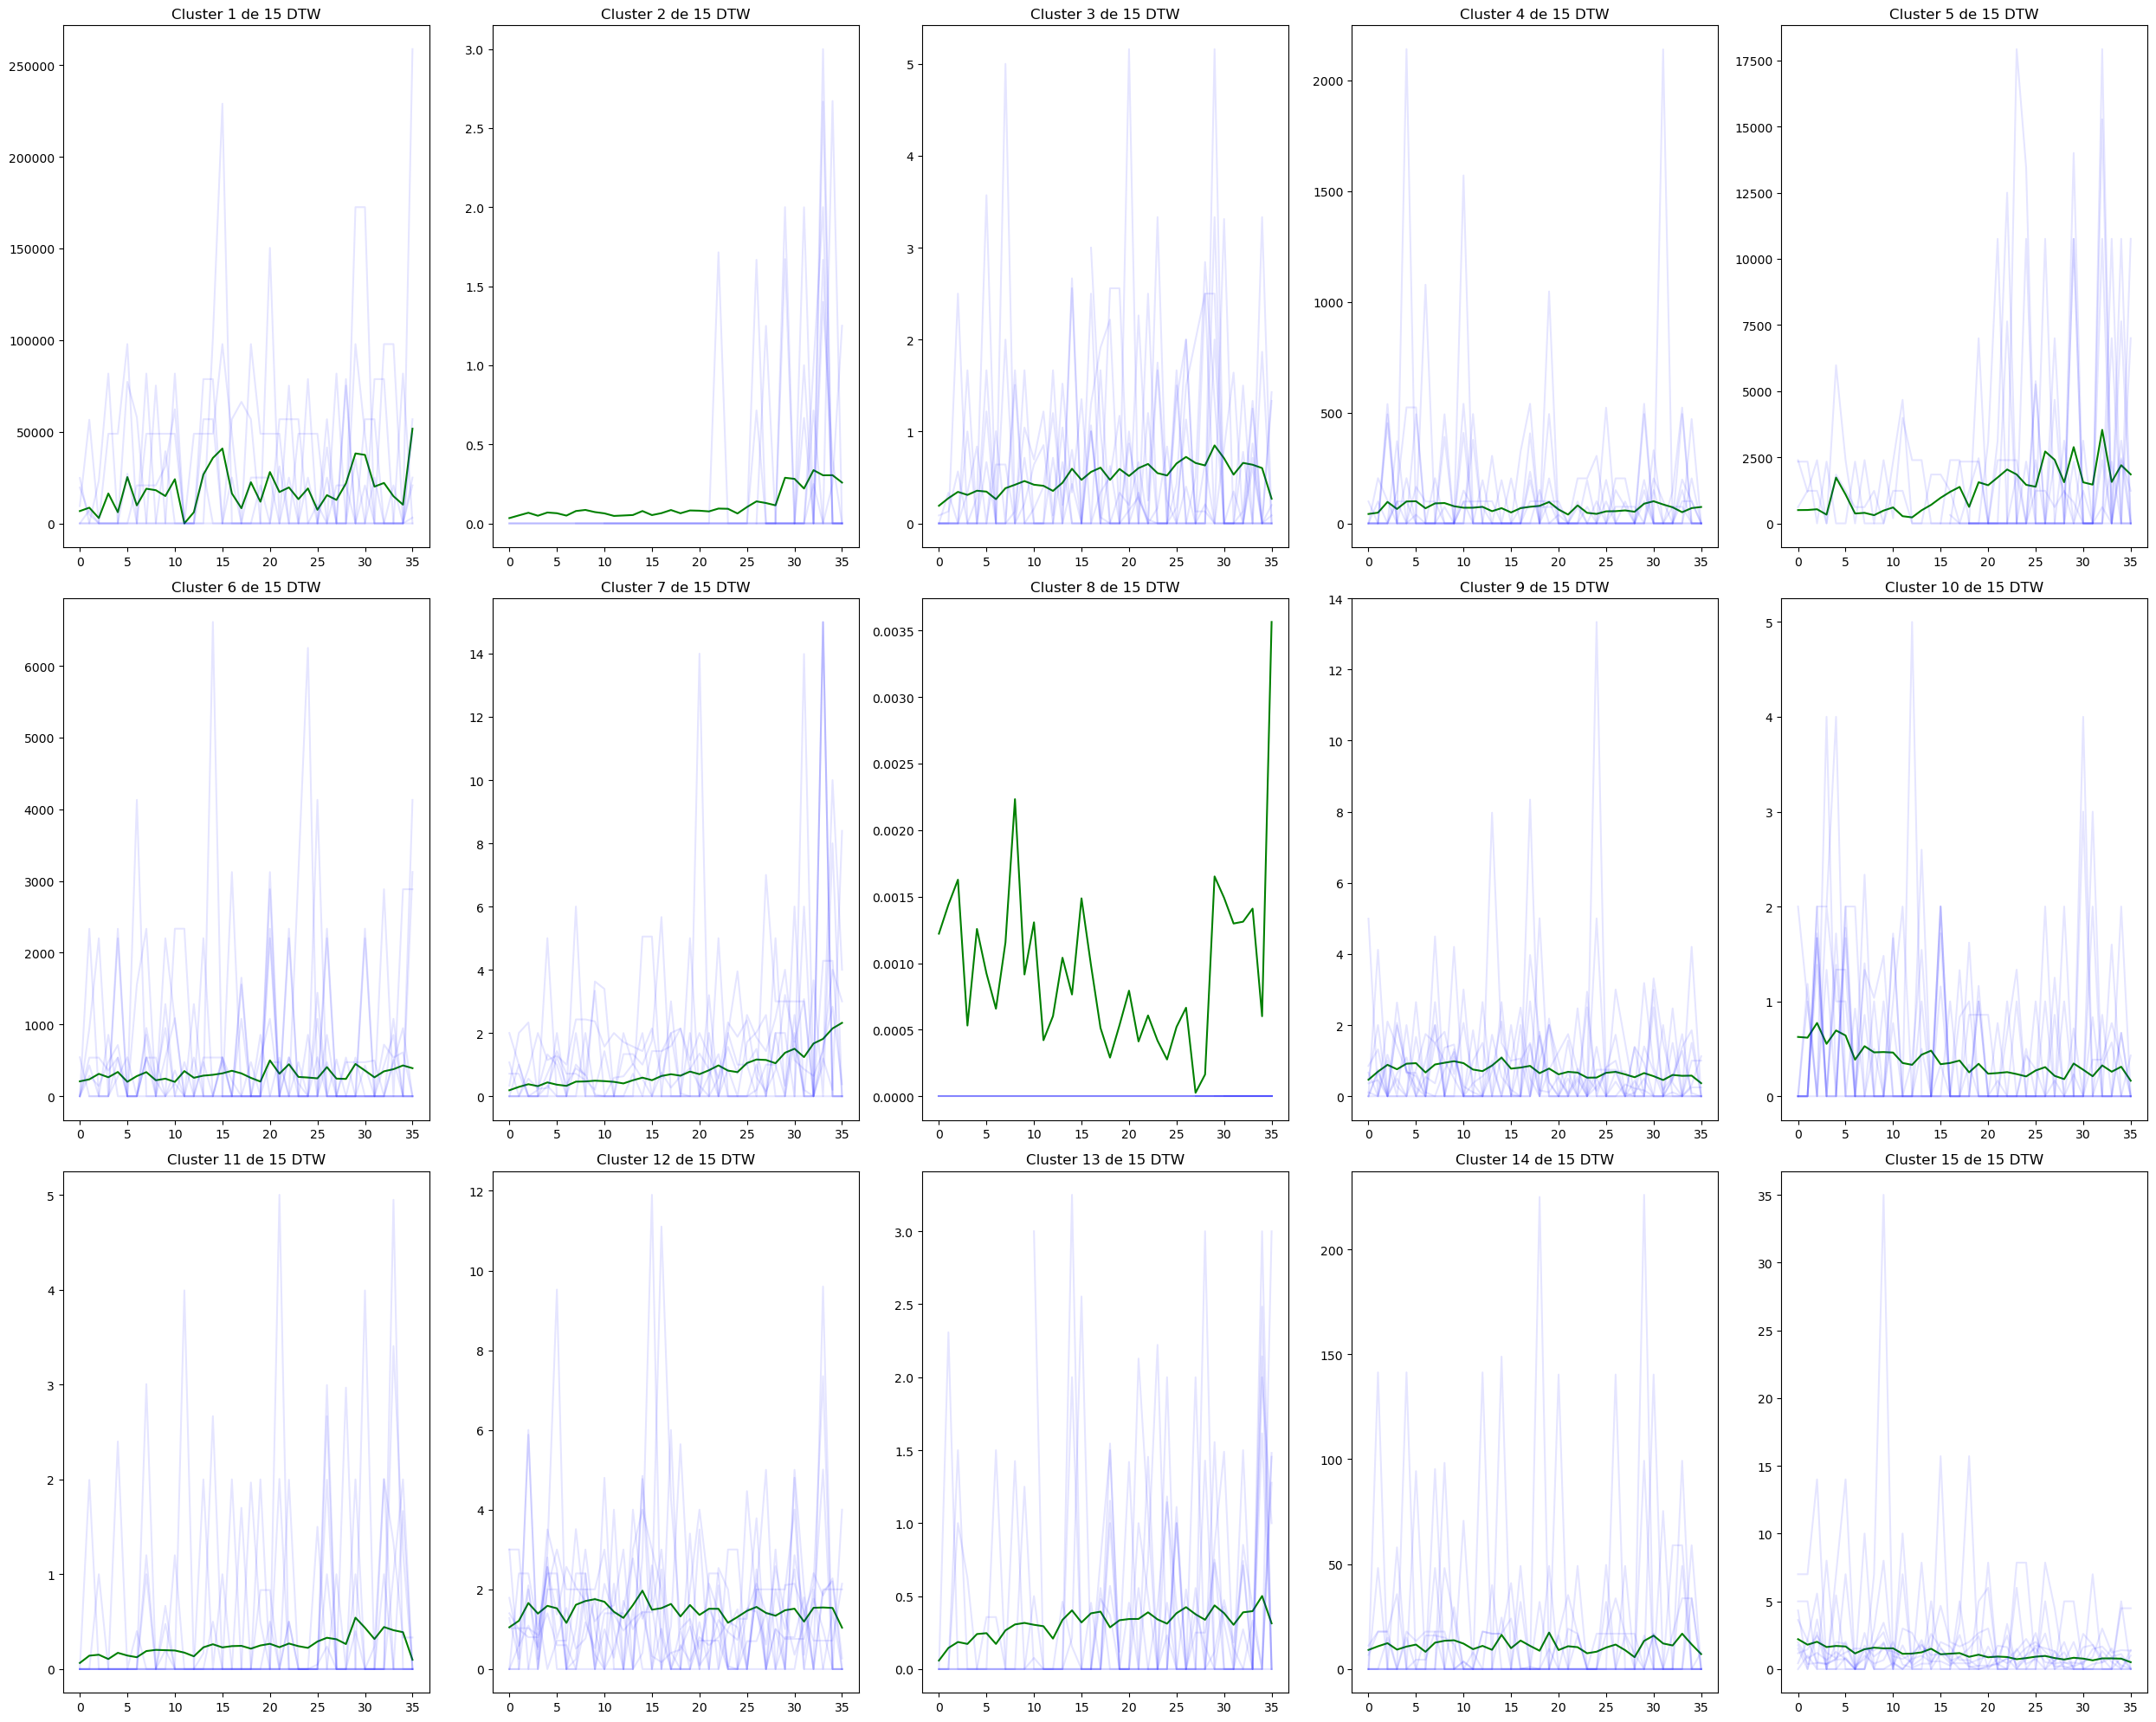

In [79]:
sample = 10
dibu_sample = pd.DataFrame()
fig, axs = plt.subplots(3, 5, figsize=(25, 20))

y_pred = x_clusters_dtw

for j in range(clusters[0]):
    axs[j//5, j%5].plot(model.cluster_centers_[j].ravel(), color='green')
    axs[j//5, j%5].set_title(f"Cluster {j+1} de {clusters[0]} DTW")
    try:
        dibu_sample = dibu[dibu['cluster']==j].sample(min(dibu[dibu['cluster']==j].shape[0],sample), random_state=42)
    except:
        continue
    
    for s in range(min(dibu_sample.shape[0],sample)):
        axs[j//5, j%5].plot(dibu_sample.iloc[s,3:].values, color='blue', alpha=0.1)

plt.tight_layout()

plt.show()

In [58]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



